In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

In [3]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/home-credit-default-risk'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/home-credit-default-risk/HomeCredit_columns_description.csv
/content/drive/MyDrive/home-credit-default-risk/POS_CASH_balance.csv
/content/drive/MyDrive/home-credit-default-risk/application_test.csv
/content/drive/MyDrive/home-credit-default-risk/application_train.csv
/content/drive/MyDrive/home-credit-default-risk/bureau.csv
/content/drive/MyDrive/home-credit-default-risk/bureau_balance.csv
/content/drive/MyDrive/home-credit-default-risk/credit_card_balance.csv
/content/drive/MyDrive/home-credit-default-risk/installments_payments.csv
/content/drive/MyDrive/home-credit-default-risk/previous_application.csv
/content/drive/MyDrive/home-credit-default-risk/sample_submission.csv


# Utils

In [4]:
def merge_dfs(df_main, df_merge):
    df_main = df_main.merge(right=df_merge.reset_index(), how='left', on='SK_ID_CURR')
    return df_main

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


def visualize_new_features(df, target, new_features_list):
    plt.figure(figsize = (8, 6))

    for i, feature in enumerate(new_features_list):

        plt.subplot(4, 1, i + 1)

        sns.kdeplot(df.loc[df[target] == 0, feature], label = 'target == 0')
        sns.kdeplot(df.loc[df[target] == 1, feature], label = 'target == 1')

        plt.title('Distribution of %s by Target Value' % feature)
        plt.xlabel('%s' % feature); plt.ylabel('Density');

    plt.tight_layout(h_pad = 2.5)

In [8]:
import pandas as pd
import plotly.graph_objects as go


def visualize_missing_values(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]

    trace = go.Bar(x=missing_values.index,
                   y=missing_values.values,
                   marker=dict(color='orange'))

    layout = go.Layout(title='Missing Values by Feature',
                       xaxis=dict(title='Features'),
                       yaxis=dict(title='Number of Missing Values'))

    fig = go.Figure(data=[trace], layout=layout)

    fig.show()

In [9]:
def find_unique_features(train_set, test_set):
    unique_features = set(test_set.columns) - set(train_set.columns)
    return unique_features

In [10]:
def drop_unique_features(test_set, unique_features):
    test_set = test_set.drop(columns=unique_features)
    return test_set

# Работа с данными

In [11]:
#df = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/файл.csv')

app_train = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/application_train.csv')
app_test = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/application_test.csv')
subm = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/sample_submission.csv')

In [12]:
pos_cash = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/POS_CASH_balance.csv')
credit_card = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/credit_card_balance.csv')
bureau = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/bureau_balance.csv')
previous_app = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/previous_application.csv')
install_payments = pd.read_csv('/content/drive/MyDrive/home-credit-default-risk/installments_payments.csv')

In [13]:
prev_apps_count = previous_app[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
previous_app['SK_ID_PREV'] = previous_app['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])

prev_apps_avg = previous_app.groupby('SK_ID_CURR')[previous_app.select_dtypes(include='number').columns].mean()
prev_apps_avg.columns = ['P_' + col for col in prev_apps_avg.columns]

app_train = merge_dfs(app_train, prev_apps_avg)
app_test = merge_dfs(app_test, prev_apps_avg)

In [14]:
bureau_avg = bureau.groupby('SK_ID_CURR')[bureau.select_dtypes(include='number').columns].mean()
bureau_avg['BUREAU_COUNT'] = bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
bureau_avg.columns = ['B_' + col for col in bureau_avg.columns]

app_train = merge_dfs(app_train, bureau_avg)
app_test = merge_dfs(app_test, bureau_avg)

In [15]:
install_count = install_payments[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
install_payments['SK_ID_PREV'] = install_payments['SK_ID_CURR'].map(install_count['SK_ID_PREV'])

install_avg = install_payments.groupby('SK_ID_CURR')[install_payments.select_dtypes(include='number').columns].mean()
install_avg.columns = ['I_' + col for col in install_avg.columns]

app_train = merge_dfs(app_train, install_avg)
app_test = merge_dfs(app_test, install_avg)

In [16]:
prev_credit_count = credit_card[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
credit_card['SK_ID_PREV'] = credit_card['SK_ID_CURR'].map(prev_credit_count['SK_ID_PREV'])

avg_credit_bal = credit_card.groupby('SK_ID_CURR')[credit_card.select_dtypes(include='number').columns].mean()
avg_credit_bal.columns = ['CC_B_' + col for col in avg_credit_bal.columns]

app_train = merge_dfs(app_train, avg_credit_bal)
app_test = merge_dfs(app_test, avg_credit_bal)

In [17]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_B_AMT_RECEIVABLE_PRINCIPAL,CC_B_AMT_RECIVABLE,CC_B_AMT_TOTAL_RECEIVABLE,CC_B_CNT_DRAWINGS_ATM_CURRENT,CC_B_CNT_DRAWINGS_CURRENT,CC_B_CNT_DRAWINGS_OTHER_CURRENT,CC_B_CNT_DRAWINGS_POS_CURRENT,CC_B_CNT_INSTALMENT_MATURE_CUM,CC_B_SK_DPD,CC_B_SK_DPD_DEF
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Добавление новых признаков

In [18]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

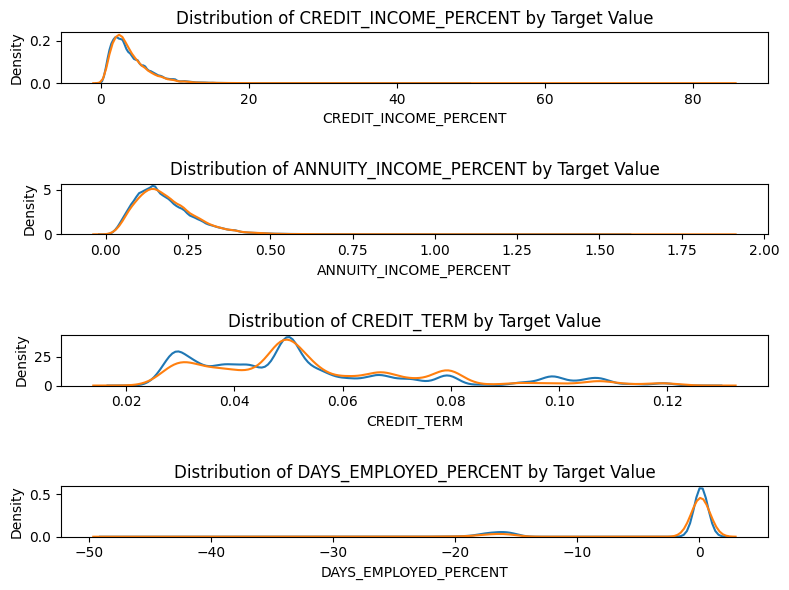

In [19]:
visualize_new_features(app_train_domain, "TARGET", ['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT'])

In [20]:
unique_features_test_set = find_unique_features(app_train_domain, app_test_domain)
app_test_domain = drop_unique_features(app_test_domain, unique_features_test_set)

In [21]:
labels = app_train['TARGET']

In [22]:
app_train_domain.drop(['SK_ID_CURR', 'TARGET'], axis=1, inplace=True)
app_test_domain.drop(['SK_ID_CURR'], axis=1, inplace=True)

In [23]:
num_features = app_train_domain.select_dtypes(include=['number']).columns
cat_features = app_train_domain.select_dtypes(include=['object']).columns

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

In [26]:
train_processed = preprocessor.fit_transform(app_train_domain)

feature_names = []
for name, transformer, columns in preprocessor.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        feature_names.extend(transformer.get_feature_names_out(columns))
    else:
        feature_names.extend(columns)

train_processed = pd.DataFrame(train_processed, columns=feature_names)

test_processed = preprocessor.transform(app_test_domain)
test_processed = pd.DataFrame(test_processed, columns=feature_names)

In [27]:
train_processed.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,-0.577538,0.142129,-0.478095,-0.166143,-0.507236,-0.149452,1.506880,-0.456215,0.379837,0.579154,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-0.577538,0.426792,1.725450,0.592683,1.600873,-1.252750,-0.166821,-0.460115,1.078697,1.790855,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.577538,-0.427196,-1.152888,-1.404669,-1.092145,-0.783451,-0.689509,-0.453299,0.206116,0.306869,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.577538,-0.142533,-0.711430,0.177874,-0.653463,-0.928991,-0.680114,-0.473217,-1.375829,0.369143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.577538,-0.199466,-0.213734,-0.361749,-0.068554,0.563570,-0.892535,-0.473210,0.191639,-0.307263,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [28]:
print(train_processed.columns[train_processed.isnull().any()])
print(test_processed.columns[test_processed.isnull().any()])

Index([], dtype='object')
Index([], dtype='object')


# Cross-validation

In [31]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.6 MB/s eta 0:00:00


In [32]:
import numpy as np
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier


def cross_validate_model(model, X, y, cv):
    auc_scores = []

    for fold, (train_index, val_index) in enumerate(cv.split(X, y)):
        X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
        y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

        if isinstance(model, CatBoostClassifier):
            model.fit(X_train_cv, y_train_cv, eval_set=(X_val_cv, y_val_cv), verbose=False)
            y_pred_prob = model.predict_proba(X_val_cv)[:, 1]
        else:
            model.fit(X_train_cv, y_train_cv)
            y_pred_prob = model.predict(X_val_cv)

        auc_score = roc_auc_score(y_val_cv, y_pred_prob)
        auc_scores.append(auc_score)

    return np.mean(auc_scores)

In [37]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


stk_fold = StratifiedKFold(n_splits = 5, shuffle = False)

# Catboost

In [38]:
cb_model = CatBoostClassifier(verbose=0)

In [39]:
scores = cross_val_score(cb_model, train_processed, labels, cv=stk_fold, scoring='roc_auc')

In [40]:
print(f'ROC AUC Score: {scores.mean()}')

ROC AUC Score: 0.7713354365288083
